![Digital Earth Pacific](dep.png)

### Digital Earth Pacific Notebook 2 Predict Random Forest Machine Learning (ML) Model

The objective of this notebook is to run the prediction based on the machine learning model that you trained in notebook 1. 

Through the notebook you will be working through the following steps: 

1. **Setting up your area of interest**  
2. **Setting up your time of interest** 
3. **Run the machine learning model to do a predicted classification of every pixel within your area of interest at your time of interest using the trained model from notebook 1**  
4. **Exploring the model outputs in an interactive map**  

In [1]:
import geopandas as gpd
import joblib
import sklearn
import numpy as np
import odc.geo.xr  # noqa
from dask import config
from dask.distributed import Client as dask_client
from odc.stac import load
from pystac_client import Client
from shapely import geometry
import depal_ck as dep
from depal_ck import predict_xr
from model import get_overlay
from ipyleaflet import Map, LayersControl, basemaps
import matplotlib.pyplot as plt
import rioxarray


In [2]:
%reload_ext autoreload
%autoreload 2

config.set({'distributed.worker.daemon': False})

## Find and load data

Load data and set up your array to use for prediction

In [3]:
aoi = gpd.read_file("Fiji/ndti_navua.geojson")

In [4]:
# Configure some things up front
chunks = dict(x=2048, y=2048)
year = "2017"
country_code = "mh"
model_file_name = "fjfj_navua_lulc.model"
datetime = year
# aoi = dep.get_country_admin_boundary("Marshall Islands", "Atoll", "Majuro")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [5]:
catalog = "https://earth-search.aws.element84.com/v1"
client = Client.open(catalog)

# Search for Sentinel-2 data
items = client.search(
    collections=["sentinel-2-c1-l2a"],
    bbox=bbox,
    datetime="2018",
    query={"eo:cloud_cover": {"lt": 30 }},
).item_collection()

print(f"Found {len(items)} items")

Found 10 items


In [6]:
# Search for Sentinel-2 GeoMAD data
# median = 

# Load the data
# data = load(items, chunks=chunks, bbox=bbox, resolution=10).squeeze("time")
data = load(items, chunks=chunks, bbox=bbox, resolution=10)

#coastal clip
#data = dep.do_coastal_clip(aoi, data, buffer=0)
data = data

In [7]:
data = data.isel(time=5)

In [8]:
data["mndwi"] = (data["green"] - data["swir16"]) / (data["green"] + data["swir16"])
mndwi = data.mndwi
water_mask = data.where(data.mndwi>0.85)
# water_mask.plot.imshow()

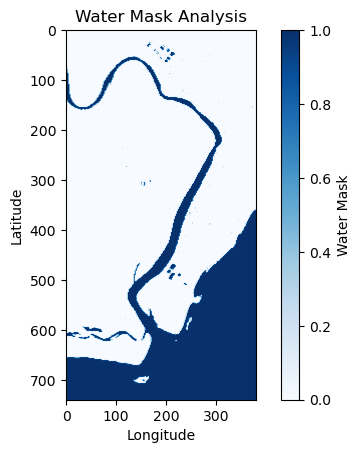

In [9]:
import matplotlib.pyplot as plt

# Calculate MNDWI
mndwi = data.mndwi

# Create the water mask
water_mask = mndwi < 0.85

# Select a specific time step for analysis
water_mask_analysis = water_mask

# Plot the water mask using imshow from matplotlib
plt.imshow(water_mask_analysis.values, cmap="Blues", vmin=0, vmax=1)
plt.colorbar(label='Water Mask')
plt.title('Water Mask Analysis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
data["ndti"] = (data["red"] - data["green"]) / (data["red"] + data["green"])

In [11]:
# # # Assign the calculated NDTI back to the data
# # data["ndti"] = ndti

# # Apply the water mask
# data_ndti = data["ndti"].where(water_mask)

In [12]:
data_ndti = data.where(water_mask)

In [13]:
data_ndti

<xarray.Dataset> Size: 25MB
Dimensions:      (y: 740, x: 381)
Coordinates:
  * y            (y) float64 6kB 7.987e+06 7.987e+06 ... 7.979e+06 7.979e+06
  * x            (x) float64 3kB 6.201e+05 6.201e+05 ... 6.239e+05 6.239e+05
    spatial_ref  int32 4B 32760
    time         datetime64[ns] 8B 2018-07-26T22:31:05.345000
Data variables: (12/20)
    red          (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    green        (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    blue         (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    visual       (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    nir          (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    swir22       (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    ...           ...
    coastal      (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    nir09        (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    cloud        (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    snow         (y, x) float32 1MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    mndwi        (y, x) float64 2MB dask.array<chunksize=(740, 381), meta=np.ndarray>
    ndti         (y, x) float64 2MB dask.array<chunksize=(740, 381), meta=np.ndarray>

In [14]:
# Select a specific time step for analysis
# ndti_analysis = ndti_water.isel(time=5)
ndti_analysis = data_ndti.ndti

In [15]:
ndti_analysis = ndti_analysis.where(water_mask)

In [16]:
ndti_analysis

<xarray.DataArray 'ndti' (y: 740, x: 381)> Size: 2MB
dask.array<where, shape=(740, 381), dtype=float64, chunksize=(740, 381), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6kB 7.987e+06 7.987e+06 ... 7.979e+06 7.979e+06
  * x            (x) float64 3kB 6.201e+05 6.201e+05 ... 6.239e+05 6.239e+05
    spatial_ref  int32 4B 32760
    time         datetime64[ns] 8B 2018-07-26T22:31:05.345000

In [17]:
data_ndti.plot.imshow(cmap="magma")

AttributeError: 'DatasetPlotAccessor' object has no attribute 'imshow'

In [18]:
# Ensure the DataArray contains only numeric values and fill NaNs with a specific value if needed
data_ndti = data_ndti.where(np.isfinite(data_ndti), np.nan)
data_ndti = data_ndti.rio.write_crs("EPSG:4326")  # Example CRS, modify as needed

In [19]:
data_ndti.rio.to_raster("ndti_turbidity.tiff")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [20]:
import numpy as np
import xarray as xr

# Assuming `ndti` is your xarray DataArray containing NDTI values
# Compute the minimum and maximum values
ndti_min = data_ndti.min().compute()
ndti_max = data_ndti.max().compute()

# Apply Min-Max scaling to normalize to the range of -1 to 1
ndti_normalized = 2 * ((data_ndti - ndti_min) / (ndti_max - ndti_min)) - 1

# # Print the minimum and maximum of the normalized NDTI to verify
# print(ndti_normalized.min().compute().item(), ndti_normalized.max().compute().item())

# Print the minimum and maximum of the normalized NDTI to verify
print(ndti_normalized.min().compute(), ndti_normalized.max().compute())

<xarray.Dataset> Size: 104B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B 2018-07-26T22:31:05.345000
    spatial_ref  int64 8B 0
Data variables: (12/20)
    red          float32 4B -1.0
    green        float32 4B -1.0
    blue         float32 4B -1.0
    visual       float32 4B -1.0
    nir          float32 4B -1.0
    swir22       float32 4B -1.0
    ...           ...
    coastal      float32 4B -1.0
    nir09        float32 4B -1.0
    cloud        float32 4B -1.0
    snow         float32 4B nan
    mndwi        float64 8B -1.0
    ndti         float64 8B -1.0 <xarray.Dataset> Size: 104B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B 2018-07-26T22:31:05.345000
    spatial_ref  int64 8B 0
Data variables: (12/20)
    red          float32 4B 1.0
    green        float32 4B 1.0
    blue         float32 4B 1.0
    visual       float32 4B 1.0
    nir          float32 4B 1.0
    swir22       float32 4B 1.0
    ...           ...
    coastal      fl

In [22]:
ndti_normalized.ndti.rio.to_raster("ndti_water.tiff")

In [66]:
# Define the target projection (CRS)
target_crs = "EPSG:3857"  # Example: Web Mercator projection

# Reproject the raster to the target projection
reprojected_raster = ndti_normalized.rio.reproject(target_crs)

# Save the reprojected raster to a new file
reprojected_raster.rio.to_raster("ndti_turbidity_reprojected.tiff")

CPLE_AppDefinedError: Too many points (441 out of 441) failed to transform, unable to compute output bounds.

In [ ]:
data_ndti.isel(time=5).plot.imshow(cmap="magma")

In [63]:
ndti_analysis = ndti_analysis.where(data.mndwi>0.85)

In [67]:
ndti_analysis.plot.imshow(cmap="magma")

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

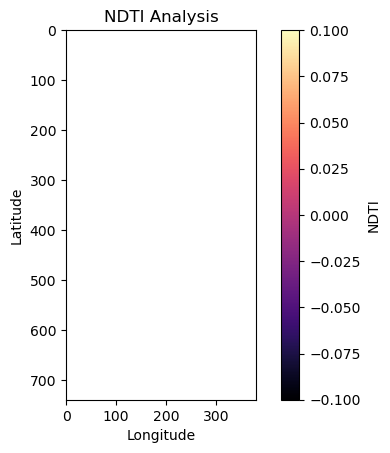

In [68]:
import matplotlib.pyplot as plt

# Select a specific time step for analysis
ndti_analysis = ndti_water.isel(time=5)

# Mask out the water areas
water_mask_time = water_mask.isel(time=5)
ndti_analysis_masked = ndti_analysis.where(~water_mask_time, np.nan)

# Convert to numpy array
ndti_analysis_masked_values = ndti_analysis_masked.values

# Plot the NDTI analysis using imshow from matplotlib
# plt.imshow(ndti_analysis_masked_values, cmap="magma", vmin=-1, vmax=1)
plt.imshow(ndti_analysis_masked_values, cmap="magma")
plt.colorbar(label='NDTI')
plt.title('NDTI Analysis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

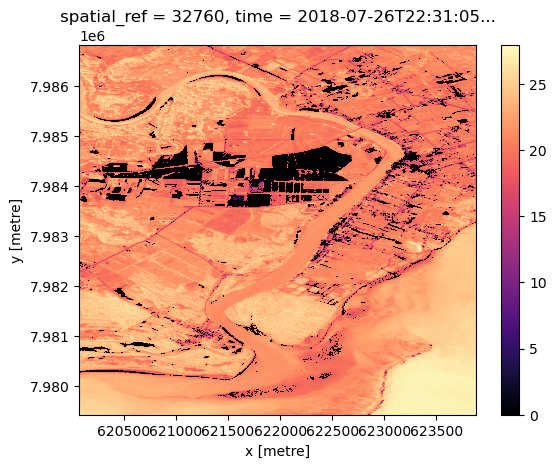

In [71]:

ndti_analysis = ndti.isel(time=5)
ndti_analysis.plot.imshow(cmap="magma")

In [72]:
ndti_water = ndti.where(water_mask)
ndti_water
# Write the GeoTIFF file
# ndti_water.rio.to_raster("ndti_water.tiff")
# ndti_water.odc.write_cog("ndti_water.tiff")
# ndti_water.odc.explore(cmap="magma")

<xarray.DataArray (time: 10, y: 740, x: 381)> Size: 23MB
dask.array<where, shape=(10, 740, 381), dtype=float64, chunksize=(1, 740, 381), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6kB 7.987e+06 7.987e+06 ... 7.979e+06 7.979e+06
  * x            (x) float64 3kB 6.201e+05 6.201e+05 ... 6.239e+05 6.239e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 80B 2018-01-22T22:30:58.757000 ... 201...

In [73]:
ndti_water.isel(time=5).rio.to_raster("ndti_water.tiff")

In [74]:
# image = ndti_water.ndti.isel(time=5)

In [75]:
image = ndti_water.isel(time=5)

In [76]:
# image.plot.imshow(x='longitude', y='latitude', rgb='true_color', vmin=-0.3, vmax=0.3, norm=norm, size=10)

In [23]:
ndti_test = data.ndti.isel(time=5)

In [25]:
ndti_water = ndti_test.where(water_mask)


In [28]:
ndti_water = ndti_water.transpose('time', 'y', 'x')
ndti_water.rio.to_raster("ndti_water.tiff")

In [27]:
ndti_water.rio.to_raster("ndti_water.tiff")

InvalidDimensionOrder: Invalid dimension order. Expected order: ('time', 'y', 'x'). You can use `DataArray.transpose('time', 'y', 'x')` to reorder your dimensions. Data variable: ndti

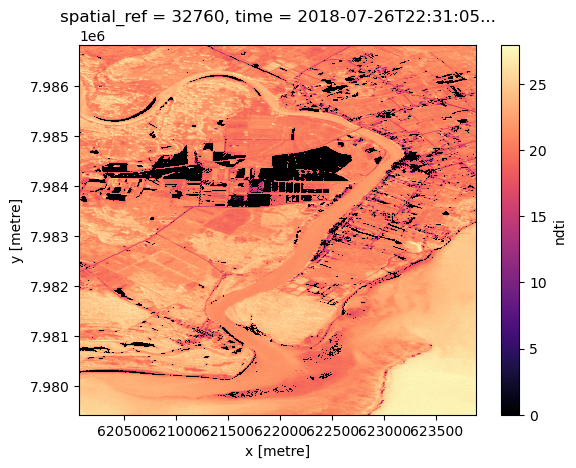

In [22]:
ndti_test.plot.imshow(cmap="magma")

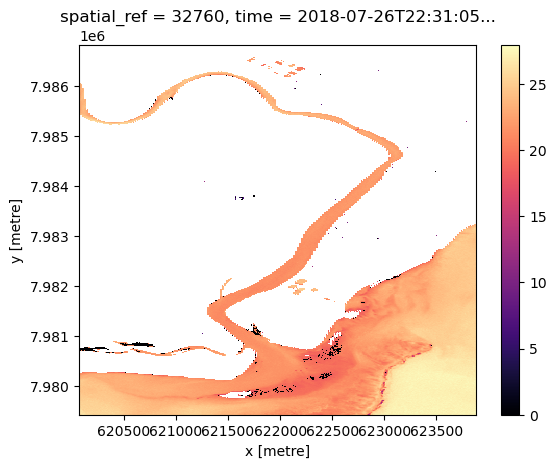

In [77]:
image.plot.imshow(cmap="magma")

In [78]:
image = image.where(water_mask)
image

<xarray.DataArray (y: 740, x: 381, time: 10)> Size: 23MB
dask.array<where, shape=(740, 381, 10), dtype=float64, chunksize=(740, 381, 1), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6kB 7.987e+06 7.987e+06 ... 7.979e+06 7.979e+06
  * x            (x) float64 3kB 6.201e+05 6.201e+05 ... 6.239e+05 6.239e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 80B 2018-01-22T22:30:58.757000 ... 201...

In [79]:
image = image.transpose('time', 'y', 'x')
image.rio.to_raster("ndti_water.tiff")

In [80]:
ndti_analysis_masked_values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [37]:

# Select a specific time step for analysis
ndti_analysis = ndti_water.isel(time=5)

# Mask out the water areas
water_mask_time = water_mask.isel(time=5)
ndti_analysis_masked = ndti_analysis.where(~water_mask_time, np.nan)

# Ensure the masked data has the correct spatial attributes (CRS)
ndti_analysis_masked = ndti_analysis_masked.rio.write_crs("EPSG:4326")  # Example CRS, modify as needed

# Save the masked NDTI analysis as a GeoTIFF
ndti_analysis_masked.rio.to_raster("ndti_water.tiff")

In [34]:
ndti_analysis_masked_values.rio.to_raster("ndti_water.tiff")

AttributeError: 'numpy.ndarray' object has no attribute 'rio'

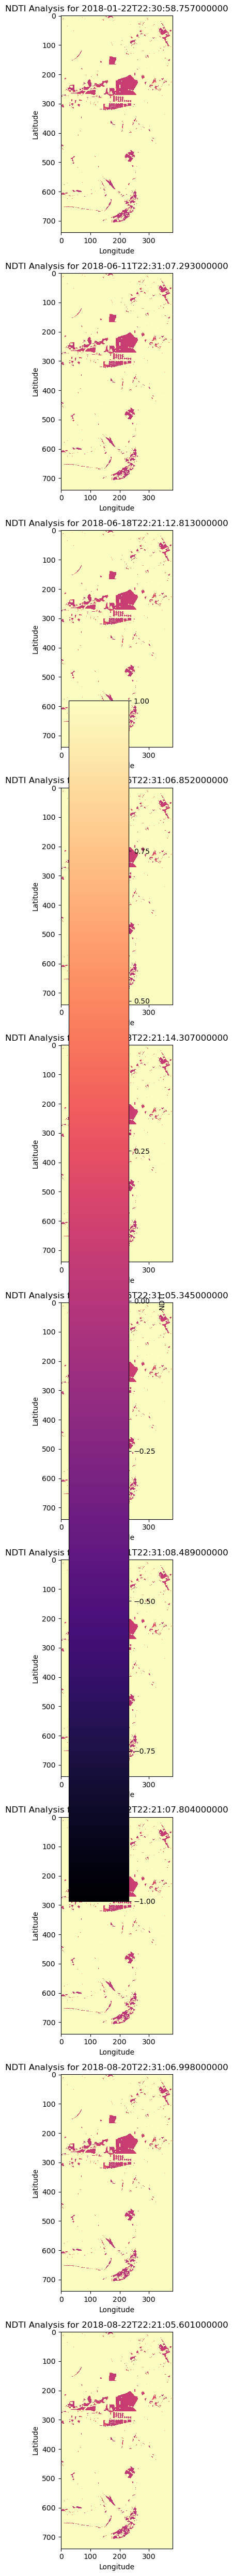

In [30]:
# Plot the NDTI for each time step
time_steps = data["time"]
num_time_steps = len(time_steps)

fig, axes = plt.subplots(nrows=num_time_steps, ncols=1, figsize=(10, 5 * num_time_steps))

for i, time_step in enumerate(time_steps):
    ndti_analysis_masked_values = data["ndti"].sel(time=time_step)
    
    # Plot the NDTI analysis using imshow from matplotlib
    im = axes[i].imshow(ndti_analysis.values, cmap="magma", vmin=-1, vmax=1)
    axes[i].set_title(f'NDTI Analysis for {str(time_step.values)}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')

# Add a colorbar to the plot
fig.colorbar(im, ax=axes, orientation='vertical', label='NDTI')

plt.tight_layout()
plt.show()